# OMMX AdapterでQUBOからサンプリングする

ここでは巡回セールスマン問題を例として、問題をQUBOに変換しサンプリングを行う方法を説明します。

```{figure} ./assets/taraimawashi_businessman.png
[たらい回しのイラスト（スーツ・男性）](https://www.irasutoya.com/2017/03/blog-post_739.html)
```

巡回セールスマン問題（TSP）は一人のセールスマンが複数の都市を順番に巡る方法を求める問題です。都市間の移動コストが与えられたときコストが最小になる経路を求めます。ここでは次の都市の配置を考えましょう

In [1]:
# From ulysses16.tsp in TSPLIB
ulysses16_points = [
    (38.24, 20.42),
    (39.57, 26.15),
    (40.56, 25.32),
    (36.26, 23.12),
    (33.48, 10.54),
    (37.56, 12.19),
    (38.42, 13.11),
    (37.52, 20.44),
    (41.23, 9.10),
    (41.17, 13.05),
    (36.08, -5.21),
    (38.47, 15.13),
    (38.15, 15.35),
    (37.51, 15.17),
    (35.49, 14.32),
    (39.36, 19.56),
]

都市の位置をプロットしてみましょう

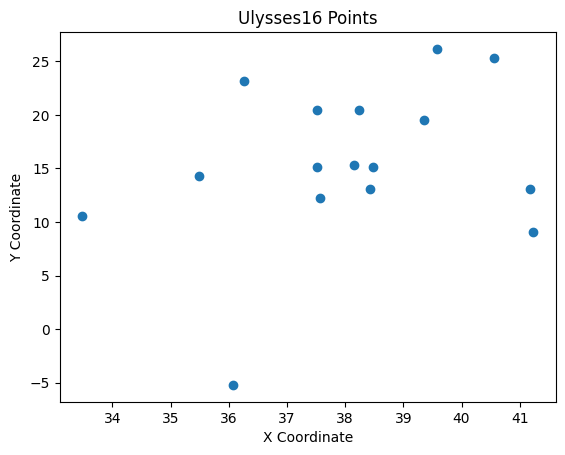

In [2]:
%matplotlib inline
from matplotlib import pyplot as plt

x_coords, y_coords = zip(*ulysses16_points)
plt.scatter(x_coords, y_coords)
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.title('Ulysses16 Points')
plt.show()

コストとして単純に移動距離を考えましょう。$i$番目の都市と$j$番目の都市の距離 $d(i, j)$を計算しておきます。

In [3]:
def distance(x, y):
    return ((x[0] - y[0])**2 + (x[1] - y[1])**2)**0.5

# 都市の数
N = len(ulysses16_points)
# 各都市間の距離
d = [[distance(ulysses16_points[i], ulysses16_points[j]) for i in range(N)] for j in range(N)]

これを使って次のような最適化問題としてTSPを定式化します。まずある時刻 $t$ に都市 $i$ にいるかどうかをバイナリ変数 $x_{t, i}$ で表します。このとき、以下の制約を満たすような $x_{t, i}$ を求めます。するとセールスマンが移動する距離は次で与えられます：

$$
\sum_{t=0}^{N-1} \sum_{i, j = 0}^{N-1} d(i, j) x_{t, i} x_{(t+1 \% N), j}
$$

ただし $x_{t, i}$ は自由に取れるわけではなく、各時刻 $t$ において一箇所の都市にしかいられないという制約と各都市について一度だけ訪れるという制約

$$
\sum_{i=0}^{N-1} x_{t, i} = 1, \quad \sum_{t=0}^{N-1} x_{t, i} = 1
$$

を満たす必要があります。これらを合わせてTSPは制約付き最適化問題として定式化できます

$$
\begin{align*}
\min \quad & \sum_{t=0}^{N-1} \sum_{i, j = 0}^{N-1} d(i, j) x_{t, i} x_{(t+1 \% N), j} \\
\text{s.t.} \quad & \sum_{i=0}^{N-1} x_{t, i} = 1 \quad (\forall t = 0, \ldots, N-1) \\
\quad & \sum_{t=0}^{N-1} x_{t, i} = 1 \quad (\forall i = 0, \ldots, N-1)
\end{align*}
$$

これに対応する `ommx.v1.Instance` は次のように作成できます

In [4]:
from ommx.v1 import DecisionVariable, Instance

x = [[
        DecisionVariable.binary(
            i + N * t,  # 決定変数のID
            name="x",           # 決定変数の名前、解を取り出すときに使う
            subscripts=[t, i])  # 決定変数の添字、解を取り出すときに使う
        for i in range(N)
    ]
    for t in range(N)
]

objective = sum(
    d[i][j] * x[t][i] * x[(t+1) % N][j]
    for i in range(N)
    for j in range(N)
    for t in range(N)
)
place_constraint = [
    (sum(x[t][i] for i in range(N)) == 1)
        .set_id(t)  # type: ignore
        .add_name("place")
        .add_subscripts([t])
    for t in range(N)
]
time_constraint = [
    (sum(x[t][i] for t in range(N)) == 1)
        .set_id(i + N)  # type: ignore
        .add_name("time")
        .add_subscripts([i])
    for i in range(N)
]

instance = Instance.from_components(
    decision_variables=[x[t][i] for i in range(N) for t in range(N)],
    objective=objective,
    constraints=place_constraint + time_constraint,
    sense=Instance.MINIMIZE
)

バイナリの決定変数の作成時 `DecisionVariable.binary` に追加した決定変数の名前と添字は後で得られたサンプルを解釈する際に使います。

## QUBOへの変換

今回扱うOpenJijを含めて、多くのサンプラーと呼ばれるソフトウェアは制約条件を含まない定式化である QUBO (Quadratic Unconstrained Binary Optimization) で記述された目的関数を小さくするようなサンプルを生成する形で動作します。上で定式化した巡回セールスマン問題は変数は全てバイナリですが、制約条件があるためUnconstrainedではありません。そこでペナルティ法によって制約条件を目的関数に押し込む事で制約なし問題に変換します。OMMXの [`Instance.uniform_penalty_method`](https://jij-inc.github.io/ommx/python/ommx/autoapi/ommx/v1/index.html#ommx.v1.Instance.uniform_penalty_method) は等式制約付き問題

$$
\begin{align*}
\min \quad &f(x) \\
\text{s.t.} \quad &g_i(x) = 0 \quad (\forall i)
\end{align*}
$$

を一つのパラメータ $\lambda$ を持つ制約なし問題

$$
\min \quad f(x) + \lambda \sum_i g_i(x)^2
$$

に変換します。また重みパラメータを制約毎に指定したい場合は [`Instance.penalty_method`](https://jij-inc.github.io/ommx/python/ommx/autoapi/ommx/v1/index.html#ommx.v1.Instance.penalty_method) を使うと

$$
\min \quad f(x) + \sum_i \lambda_i g_i(x)^2
$$

という形に変換できます。

In [5]:
parametric_qubo = instance.uniform_penalty_method()

これは決定変数でないパラメータをもっているため `ommx.v1.Instance` ではなくて `ommx.v1.ParametricInstance` という型になっていて、次のパラメータ付きQUBOに対応します。

$$
\min \quad \sum_{t=0}^{N-1} \sum_{i, j = 0}^{N-1} d(i, j) x_{t, i} x_{(t+1 \% N), j}
+ \lambda \left[ \sum_{t=0}^{N-1} \left(\sum_{i=0}^{N-1} x_{t, i} - 1\right)^2
+ \sum_{i=0}^{N-1} \left(\sum_{t=0}^{N-1} x_{t, i} - 1\right)^2 \right]
$$

この `ParametricInstance` がどのようなパラメータを持っているかは `parameters` プロパティで確認できます。

In [6]:
parametric_qubo.parameters

,name,subscripts,description
id,,,
256,uniform_penalty_weight,[],<NA>


上で説明したように `uniform_penalty_method` は単一のペナルティ重みをパラメータとして持つので一つだけパラメータが存在します。これを $\lambda = 1.0$ に固定するには次のように `with_parameters` でパラメータを指定します。この関数はパラメータのIDに対して値を指定する辞書 `dict[int, float]` を引数に取ります。

In [7]:
weight = parametric_qubo.get_parameters()[0]
qubo = parametric_qubo.with_parameters({weight.id: 20.0})

ここで得られた `qubo` は全てのパラメータが代入されたので `ommx.v1.ParametricInstance` ではなくて `ommx.v1.Instance` になっており、また制約条件を一つも持たない制約なし最適化問題になっています。

In [8]:
assert qubo.get_constraints() == []

ただしこの `qubo` インスタンスは元の制約条件の情報を `removed_constraints` として保持しています。これはQUBOに対してサンプリングした結果が元の問題の制約条件を満たしているのかどうかを検証するための情報です。QUBOへの変換は極端な例ですが、このように数理モデルに前処理を加えることでユーザーが入力した制約条件がソルバーに渡す前に不必要になってしまうことはよくあります。このような場合でもユーザーは自分が入力した制約条件について興味があるので `ommx.v1.Instance` ではこれらの情報を保持する仕組みが備わっています。

In [9]:
qubo.removed_constraints.head(2)

,equality,type,used_ids,name,subscripts,description,removed_reason
id,,,,,,,
0,=0,linear,"{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",place,[0],<NA>,uniform_penalty_method
1,=0,linear,"{16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 2...",place,[1],<NA>,uniform_penalty_method


なおこの `qubo` インスタンスの目的関数は元の問題の目的関数とは異なっていることに注意してください。以降の処理で出てくる `objective` の値はこの新しい目的関数の値（いわゆるエネルギー値）です。


## OpenJijによるサンプリング

`ommx.v1.Instance` で記述されたQUBOをOpenJijを使ってサンプリングするには `ommx-openjij-adapter` を使います。

In [10]:
import ommx_openjij_adapter as adapter

samples = adapter.sample_qubo_sa(qubo, num_reads=16)
sample_set = qubo.evaluate_samples(samples)
sample_set.summary

,objective,feasible,feasible_unrelaxed
sample_id,,,
12,90.223996,True,True
15,92.067361,True,True
11,93.275354,True,True
2,95.008977,True,True
13,95.754809,True,True
9,96.849363,True,True
10,100.809531,True,True
7,103.081467,True,True
4,104.502201,True,True


`ommx_openjij_adapter.sample_qubo_sa` は `ommx.v1.Samples` を返し、これを `Instance.evaluate_samples` に渡すことで目的関数の値や制約条件の破れを計算できます。`SampleSet.summary` プロパティはこれらの要約情報を表示するためのものです。

- `feasible` はQUBOに変換後の `qubo` インスタンス自体の実行可能性を表示していますが、QUBOは全ての制約条件を取り除いているのでこれは常に `True` です。
- `feasible_unrelaxed` はQUBOに変換する前の、元の問題に対する実行可能性を示しています。これは `qubo` インスタンスの `removed_constraints` に格納されている情報を使って計算されます。

各制約条件毎のfeasibilityを見るには `summary_with_constraints` プロパティを使います。

In [11]:
sample_set.summary_with_constraints

,objective,feasible,feasible_unrelaxed,place[0],place[1],place[2],place[3],place[4],place[5],place[6],...,time[6],time[7],time[8],time[9],time[10],time[11],time[12],time[13],time[14],time[15]
sample_id,,,,,,,,,,,,,,,,,,,,,
12,90.223996,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True
15,92.067361,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True
11,93.275354,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True
2,95.008977,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True
13,95.754809,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True
9,96.849363,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True
10,100.809531,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True
7,103.081467,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True
4,104.502201,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True


より詳しい情報は `SampleSet.decision_variables` 及び `SampleSet.constraints` プロパティを使って取得できます。

In [12]:
sample_set.decision_variables.head(2)

,kind,lower,upper,name,subscripts,description,substituted_value,0,1,2,...,6,7,8,9,10,11,12,13,14,15
id,,,,,,,,,,,,,,,,,,,,,
0,binary,0.0,1.0,x,"[0, 0]",<NA>,<NA>,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
16,binary,0.0,1.0,x,"[1, 0]",<NA>,<NA>,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [13]:
sample_set.constraints.head(2)

,equality,used_ids,name,subscripts,description,removed_reason,value.0,value.1,value.2,value.3,...,feasible.14,feasible.6,feasible.15,feasible.12,feasible.5,feasible.8,feasible.0,feasible.13,feasible.1,feasible.4
id,,,,,,,,,,,,,,,,,,,,,
0,=0,"{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",place,[0],<NA>,uniform_penalty_method,0.0,0.0,0.0,0.0,...,True,True,True,True,False,True,True,True,True,True
1,=0,"{16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 2...",place,[1],<NA>,uniform_penalty_method,0.0,0.0,0.0,0.0,...,True,True,True,True,True,True,True,True,True,True



得られたサンプルを取得するには `SampleSet.extract_decision_variables` メソッドを使います。これは `ommx.v1.DecisionVariables` を作る時に登録した `name` と `subscripts` を使ってサンプルを解釈します。例えば `sample_id=1` の `x` という名前の決定変数の値を取得するには次のようにすると `dict[subscripts, value]` の形で取得できます。

In [14]:
sample_id = 1
x = sample_set.extract_decision_variables("x", sample_id)
t = 2
i = 3
x[(t, i)]

0.0

$x_{t, i}$に対するサンプルが得れたのでこれをTSPのパスに変換します。これは今回の定式化自体に依存するので自分で処理を書く必要があります。

In [15]:
def sample_to_path(sample: dict[tuple[int, ...], float]) -> list[int]:
    path = []
    for t in range(N):
        for i in range(N):
            if sample[(t, i)] == 1:
                path.append(i)
    return path

これを表示してみましょう。まず元の問題に対してfeasibleであるサンプルのIDを取得します。

In [16]:
feasible_ids = sample_set.summary.query("feasible_unrelaxed == True").index
feasible_ids

Index([12, 15, 11, 2, 13, 9, 10, 7, 4, 8, 3, 0], dtype='int64', name='sample_id')

これらについて最適化された経路を表示しましょう

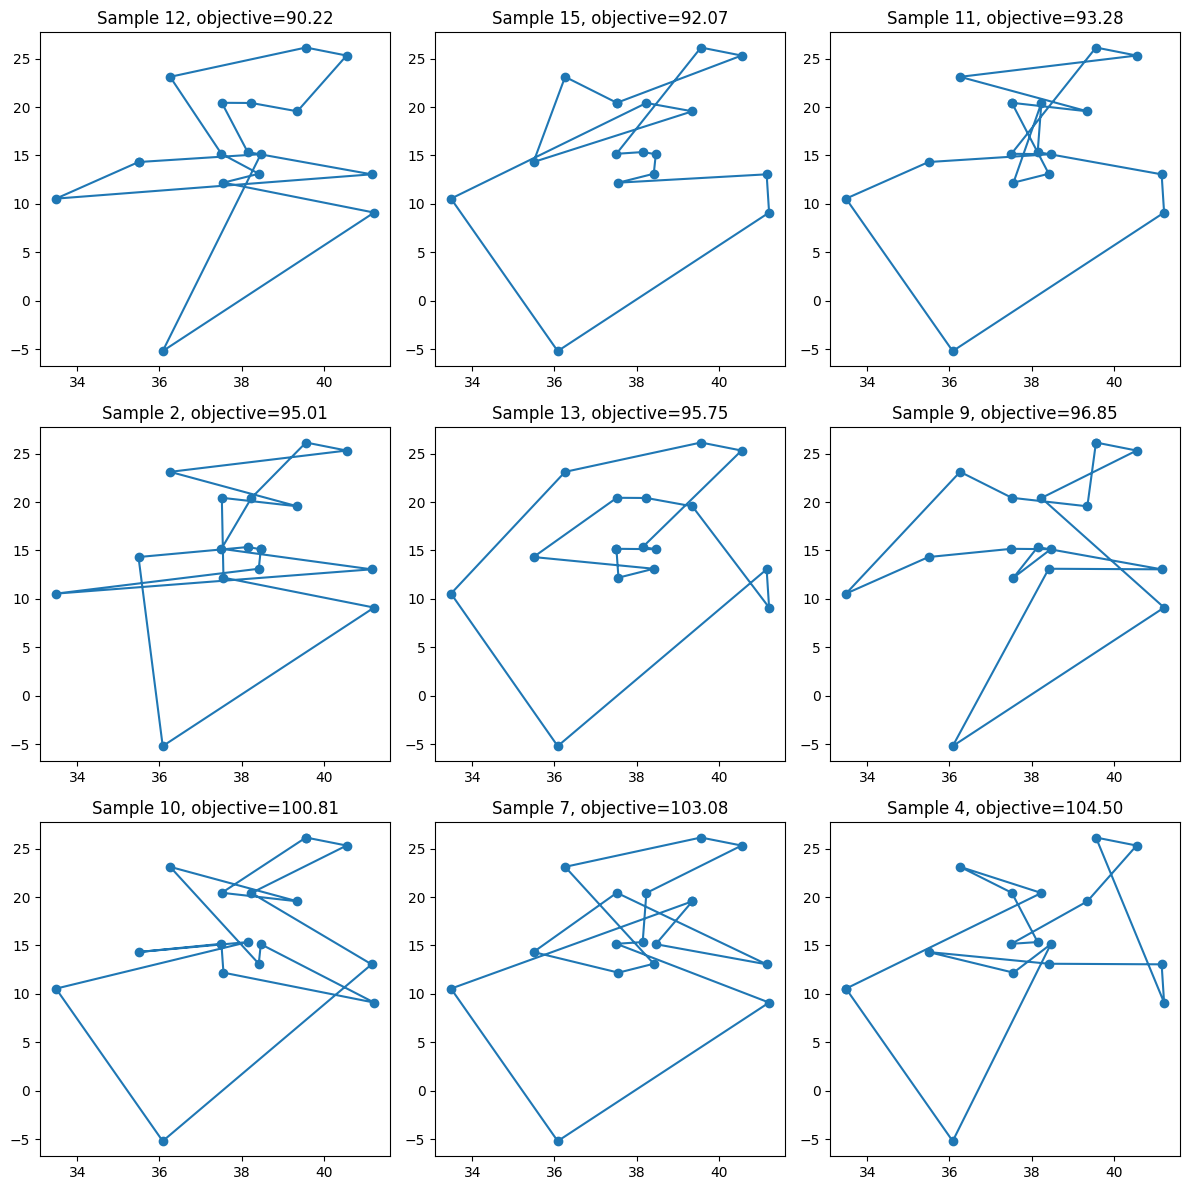

In [17]:
fig, axie = plt.subplots(3, 3, figsize=(12, 12))

for i, ax in enumerate(axie.flatten()):
    if i >= len(feasible_ids):
        break
    s = feasible_ids[i]
    x = sample_set.extract_decision_variables("x", s)
    path = sample_to_path(x)
    xs = [ulysses16_points[i][0] for i in path] + [ulysses16_points[path[0]][0]]
    ys = [ulysses16_points[i][1] for i in path] + [ulysses16_points[path[0]][1]]
    ax.plot(xs, ys, marker='o')
    ax.set_title(f"Sample {s}, objective={sample_set.objectives[s]:.2f}")

plt.tight_layout()
plt.show()